# dask

> Convenient functions for dask

In [ ]:
#| default_exp cli/dask_

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import math
import itertools
import concurrent
import logging

import numpy as np
from dask import array as da
from dask import delayed
import zarr

from moraine.cli.logging import mc_logger_

In [ ]:
#| export
def _fill_slice(data_zarr,slices):
    out_slices = []
    for i in range(len(slices)):
        slice_i = slices[i]
        if slice_i.start is None:
            start = 0
        else:
            start = slice_i.start
        assert start%data_zarr.chunks[i] == 0
        if (slice_i.stop is None) or (slice_i.stop == data_zarr.shape[i]):
            stop = data_zarr.shape[i]
        else:
            stop = slice_i.stop
            assert stop%data_zarr.chunks[i] == 0
        assert (slice_i.step is None) or (slice_i.step == 1)
        step = 1
        out_slices.append(slice(start,stop,step))
    return tuple(out_slices)

In [ ]:
#| export
def _one_chunk_slices_and_out_shape(data_zarr,slices):
    zarr_1chunk_slice = []
    out_1chunk_slice = []
    out_shape = []
    for i in range(len(slices)):
        chunk_size = data_zarr.chunks[i]
        shape = data_zarr.shape[i]
        zarr_slices = slices[i]
        start = zarr_slices.start
        stop = zarr_slices.stop
        out_shape.append(stop-start)
    
        zarr_1dim_bound = np.arange(start,stop+chunk_size,chunk_size)
        if zarr_1dim_bound[-1] > stop: zarr_1dim_bound[-1] = stop
        out_1dim_bound = zarr_1dim_bound-start

        zarr_1chunk_1dim_slice = []
        out_1chunk_1dim_slice = []
        for j in range(zarr_1dim_bound.shape[0]-1):
            zarr_1chunk_1dim_slice.append(slice(zarr_1dim_bound[j],zarr_1dim_bound[j+1]))
            out_1chunk_1dim_slice.append(slice(out_1dim_bound[j],out_1dim_bound[j+1]))

        zarr_1chunk_slice.append(zarr_1chunk_1dim_slice)
        out_1chunk_slice.append(out_1chunk_1dim_slice)

    zarr_1chunk_slice = list(itertools.product(*zarr_1chunk_slice))
    out_1chunk_slice = list(itertools.product(*out_1chunk_slice))

    return zarr_1chunk_slice, out_1chunk_slice, tuple(out_shape)

In [ ]:
#| export
def _read_one_chunk(data_zarr,out,zarr_slices,out_slices):
    out[out_slices] = data_zarr[zarr_slices]

In [ ]:
#| export
def _p_read_zarr(data_zarr,slices,thread_pool_size=None,fill_slice=True):
    if fill_slice:
        slices = _fill_slice(data_zarr,slices)
    zarr_1chunk_slices, out_1chunk_slices, out_shape = \
    _one_chunk_slices_and_out_shape(data_zarr,slices)
    # global out
    out = np.empty(out_shape,dtype=data_zarr.dtype)

    with concurrent.futures.ThreadPoolExecutor(thread_pool_size) as executor:
        for zarr_1chunk_slice,out_1chunk_slice in zip(zarr_1chunk_slices,out_1chunk_slices):
            future = executor.submit(_read_one_chunk,data_zarr,out,zarr_1chunk_slice,out_1chunk_slice)
    return out

In [ ]:
rslc_path = '/users/kangl/work/insar_denoising/NorthDallas_34_105_2019_ascending/moraine/load_data/rslc.zarr/'

In [ ]:
rslc_zarr = zarr.open(rslc_path,'r',)

In [ ]:
%%time
out = _p_read_zarr(rslc_zarr,(slice(0,13165),slice(0,68467),slice(0,1)))

CPU times: user 3.19 s, sys: 9.21 s, total: 12.4 s
Wall time: 935 ms


In [ ]:
%%time
out = rslc_zarr[:,:,0:1]

CPU times: user 2.4 s, sys: 3.7 s, total: 6.1 s
Wall time: 3.15 s


In [ ]:
np.testing.assert_array_equal(rslc_zarr[:,:,2:3],_p_read_zarr(rslc_zarr,(slice(0,13165),slice(0,68467),slice(2,3))))

In [ ]:
#| export
def _all_chunk_slices_except_pdims(data_zarr, pdims):
    out_slices = []
    for i in range(data_zarr.ndim):
        if i in pdims:
            slice_1dim = [slice(None)]
        else:
            shape = data_zarr.shape[i]
            chunk = data_zarr.chunks[i]
            bound_1dim = np.arange(0,shape+chunk,chunk)
            if bound_1dim[-1] > shape: bound_1dim[-1] = shape

            slice_1dim = []
            for j in range(bound_1dim.shape[0]-1):
                slice_1dim.append(slice(bound_1dim[j],bound_1dim[j+1]))
        out_slices.append(slice_1dim)
    out_slices = list(itertools.product(*out_slices))
    return out_slices

In [ ]:
_all_chunk_slices_except_pdims(rslc_zarr,(0,2))

[(slice(None, None, None), slice(0, 68467, None), slice(None, None, None))]

In [ ]:
#| export
def dask_from_zarr(
    data_path:str,
    parallel_dims:int|tuple,
):
    if isinstance(parallel_dims,int):
        parallel_dims = (parallel_dims,)
    data_zarr = zarr.open(data_path,'r')
    slices = _all_chunk_slices_except_pdims(data_zarr,parallel_dims)

    _p_read_zarr_delayed = delayed(_p_read_zarr,pure=True,nout=1)
    out_delayed = np.empty(len(slices),dtype=object)
    for i in range(len(slices)):
        slices_i = _fill_slice(data_zarr,slices[i])
        out_delayed[i] = _p_read_zarr_delayed(data_zarr,slices_i,fill_slice=False)
        shape = []
        for slice_ in slices_i:
            shape.append(slice_.stop-slice_.start)
        shape = tuple(shape)
        out_delayed[i] = da.from_delayed(out_delayed[i],shape=shape,dtype=data_zarr.dtype,meta=np.array((),dtype=data_zarr.dtype))

    nchunks = list(data_zarr.cdata_shape)
    for pdim in parallel_dims:
        nchunks[pdim] = 1
    out_delayed = out_delayed.reshape(tuple(nchunks))
    data_darr = da.block(out_delayed.tolist())
    return data_darr

In [ ]:
rslc_darr = dask_from_zarr('raw/rslc.zarr/',parallel_dims=(1,2))

In [ ]:
rslc_darr

dask.array<concatenate, shape=(2500, 1834, 17), dtype=complex64, chunksize=(1000, 1834, 17), chunktype=numpy.ndarray>

In [ ]:
rslc_darr.chunksize

(1000, 1834, 17)

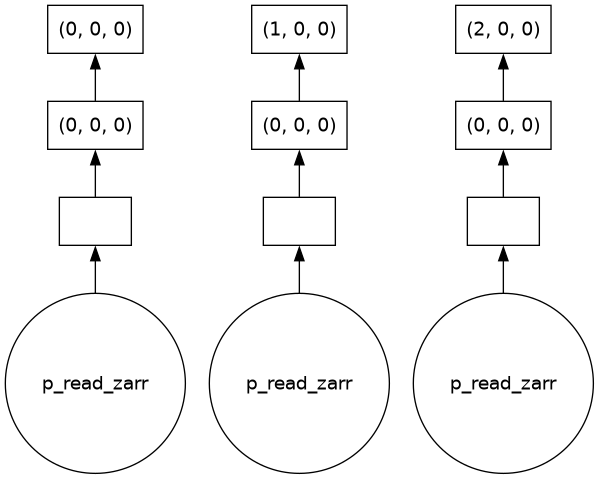

In [ ]:
rslc_darr.visualize()

In [ ]:
#| export
def _write_one_chunk(data_zarr,data,zarr_slices,data_slices):
    data_zarr[zarr_slices] = data[data_slices]

In [ ]:
#| export
def _p_write_zarr(data,data_zarr,slices,thread_pool_size=None,fill_slice=True):
    if fill_slice:
        slices = _fill_slice(data_zarr,slices)
    zarr_1chunk_slices, data_1chunk_slices = \
    _one_chunk_slices_and_out_shape(data_zarr,slices)[:2]

    with concurrent.futures.ThreadPoolExecutor(thread_pool_size) as executor:
        for zarr_1chunk_slice,data_1chunk_slice in zip(zarr_1chunk_slices,data_1chunk_slices):
            future = executor.submit(_write_one_chunk,data_zarr,data,zarr_1chunk_slice,data_1chunk_slice)

In [ ]:
out_rslc_path = './dask_/rslc.zarr'
rslc_path = '/users/kangl/work/insar_denoising/NorthDallas_34_105_2019_ascending/moraine/load_data/rslc.zarr/'
rslc_zarr = zarr.open(rslc_path,'r')
one_rslc = rslc_zarr[slice(0,13165),slice(0,68467),slice(0,1)]

In [ ]:
out_rslc_zarr = zarr.open(out_rslc_path,'w',shape=rslc_zarr.shape,dtype=rslc_zarr.dtype,chunks=rslc_zarr.chunks)

In [ ]:
%%time
out_rslc_zarr[slice(0,13165),slice(0,68467),slice(0,1)] = one_rslc

CPU times: user 8.17 s, sys: 4.03 s, total: 12.2 s
Wall time: 7.7 s


In [ ]:
%%time
_p_write_zarr(one_rslc,out_rslc_zarr,(slice(0,13165),slice(0,68467),slice(0,1)))

CPU times: user 7.96 s, sys: 10.7 s, total: 18.6 s
Wall time: 1.47 s


In [ ]:
#| export
@mc_logger_
def dask_to_zarr(data_darr,url,chunks,path=None):
    logger = logging.getLogger(__name__)
    if isinstance(url, zarr.Array):
        data_zarr = url
        logger.zarr_info(path,data_zarr)
    else:
        data_zarr = zarr.open(url,'w',shape=data_darr.shape,dtype=data_darr.dtype,chunks=chunks)
        logger.zarr_info(url,data_zarr)
    pdims = []
    for i in range(data_darr.ndim):
        if data_darr.chunksize[i] != data_zarr.chunks[i]:
            assert data_darr.chunksize[i] == data_darr.shape[i], "dask array is not properly rechunked."
            pdims.append(i)
    pdims = tuple(pdims)
    slices = _all_chunk_slices_except_pdims(data_zarr,pdims)
    n_slices = len(slices)

    _p_write_zarr_delayed = delayed(_p_write_zarr,pure=True,nout=0)
    out_delayed = np.empty(n_slices,dtype=object)
    data_darr_delayed = data_darr.to_delayed()
    data_darr_delayed = data_darr_delayed.reshape(n_slices)
    for i in range(n_slices):
        slices_i = _fill_slice(data_zarr,slices[i])
        out_delayed[i] = _p_write_zarr_delayed(data_darr_delayed[i],data_zarr,slices_i,fill_slice=False)
        out_delayed[i] = da.from_delayed(out_delayed[i],shape=(1,),dtype=int)

    return da.block(out_delayed.tolist())

In [ ]:
rslc_darr = dask_from_zarr('raw/rslc.zarr/',parallel_dims=(1,2))

In [ ]:
rslc_darr = rslc_darr.persist()

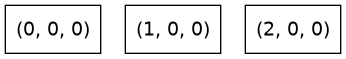

In [ ]:
rslc_darr.visualize()

In [ ]:
rslc_darr

dask.array<concatenate, shape=(2500, 1834, 17), dtype=complex64, chunksize=(1000, 1834, 17), chunktype=numpy.ndarray>

In [ ]:
out_delayed = dask_to_zarr(rslc_darr,'./dask_/rslc.zarr/',chunks=(rslc_darr.chunksize[0],rslc_darr.shape[1],1))

In [ ]:
da.compute(out_delayed)

(array([None, None, None], dtype=object),)

In [ ]:
np.testing.assert_array_equal(zarr.open('./dask_/rslc.zarr','r')[:], zarr.open('./raw/rslc.zarr','r')[:])

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()